In [1]:
# Import required libraries
import os
import cv2
from mtcnn.mtcnn import MTCNN
from PIL import Image

# Define the face extraction function using MTCNN
def extract_faces_mtcnn(video_dir, output_dir, label, resize=(128, 128), frame_skip=15, confidence_threshold=0.95):
    os.makedirs(output_dir, exist_ok=True)
    detector = MTCNN()

    for filename in os.listdir(video_dir):
        if filename.endswith(".mp4"):
            video_path = os.path.join(video_dir, filename)
            cap = cv2.VideoCapture(video_path)

            frame_idx = 0
            face_idx = 0

            while True:
                success, frame = cap.read()
                if not success:
                    break

                if frame_idx % frame_skip == 0:
                    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    detections = detector.detect_faces(rgb_frame)

                    for detection in detections:
                        if detection['confidence'] >= confidence_threshold:
                            x, y, w, h = detection['box']
                            x, y = max(0, x), max(0, y)
                            face_crop = rgb_frame[y:y+h, x:x+w]

                            face_img = Image.fromarray(face_crop)
                            face_img = face_img.resize(resize)
                            out_name = f"{label}_{os.path.splitext(filename)[0]}_face{face_idx}.jpg"
                            out_path = os.path.join(output_dir, out_name)
                            face_img.save(out_path)
                            face_idx += 1

                frame_idx += 1

            cap.release()

    print(f"✅ MTCNN face crops saved for {label}: {video_dir} → {output_dir}")

# Set directories and run for both classes
real_video_dir = "C:/Users/gavin/Documents/Dataset/VIDEO/REAL"
fake_video_dir = "C:/Users/gavin/Documents/Dataset/VIDEO/FAKE"
output_base_dir = "C:/Users/gavin/Documents/Dataset/face_crops"

extract_faces_mtcnn(real_video_dir, os.path.join(output_base_dir, "REAL"), label="REAL")
extract_faces_mtcnn(fake_video_dir, os.path.join(output_base_dir, "FAKE"), label="FAKE")


✅ MTCNN face crops saved for REAL: C:/Users/gavin/Documents/Dataset/VIDEO/REAL → C:/Users/gavin/Documents/Dataset/face_crops\REAL
✅ MTCNN face crops saved for FAKE: C:/Users/gavin/Documents/Dataset/VIDEO/FAKE → C:/Users/gavin/Documents/Dataset/face_crops\FAKE


In [2]:
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def load_face_images(real_dir, fake_dir, image_size=(128, 128)):
    images = []
    labels = []

    for label, directory in [("REAL", real_dir), ("FAKE", fake_dir)]:
        for filename in os.listdir(directory):
            if filename.endswith(".jpg"):
                path = os.path.join(directory, filename)
                img = Image.open(path).convert("RGB")
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0
                images.append(img_array)
                labels.append(label)

    return np.array(images), np.array(labels)

# Set your face crop directories
face_dir_real = "C:/Users/gavin/Documents/Dataset/face_crops/REAL"
face_dir_fake = "C:/Users/gavin/Documents/Dataset/face_crops/FAKE"

# Load data
X, y_labels = load_face_images(face_dir_real, face_dir_fake)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)  # FAKE = 0, REAL = 1
y = to_categorical(y, num_classes=2)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Step 2 complete.")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Class labels:", label_encoder.classes_)


✅ Step 2 complete.
X_train shape: (937, 128, 128, 3)
y_train shape: (937, 2)
Class labels: ['FAKE' 'REAL']


Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - accuracy: 0.5287 - loss: 1.3206 - val_accuracy: 0.7277 - val_loss: 0.6059
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.6138 - loss: 0.6795 - val_accuracy: 0.7574 - val_loss: 0.5232
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.6044 - loss: 0.6563 - val_accuracy: 0.8128 - val_loss: 0.4829
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.7136 - loss: 0.5413 - val_accuracy: 0.7532 - val_loss: 0.4782
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6999 - loss: 0.5410 - val_accuracy: 0.7830 - val_loss: 0.4282
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7366 - loss: 0.4817 - val_accuracy: 0.7872 - val_loss: 0.4064
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.7290 - loss: 0.5137 - val_accuracy: 0.8170 - val_loss: 0.3639
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.7664 - loss: 0

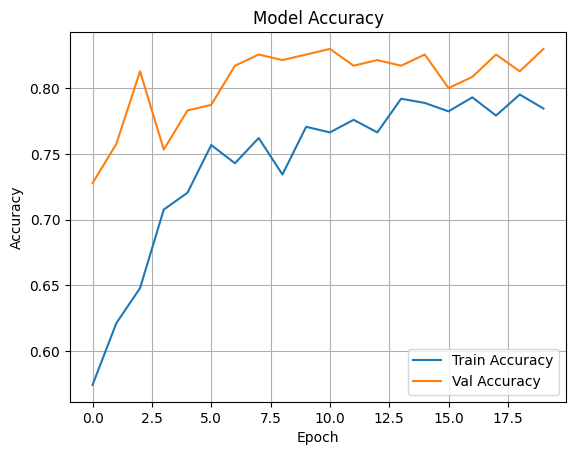

In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load MobileNetV2 base
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

# Create full model
face_model = Model(inputs=base_model.input, outputs=output)

# Compile
face_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Train
history = face_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=8,
    verbose=1
)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
face_model.save("face_deepfake_model.h5")


In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Step 4: Unfreeze the last 20 layers of MobileNetV2
for layer in face_model.layers[-20:]:
    layer.trainable = True

# ✅ Recompile with a low learning rate
face_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Optional: Stop early if val_loss stops improving
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ✅ Retrain (fine-tuning stage)
history_finetune = face_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 156ms/step - accuracy: 0.8112 - loss: 0.3482 - val_accuracy: 0.8255 - val_loss: 0.2612
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.8286 - loss: 0.3050 - val_accuracy: 0.8298 - val_loss: 0.2514
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.8341 - loss: 0.3049 - val_accuracy: 0.8255 - val_loss: 0.2538
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.8145 - loss: 0.3421 - val_accuracy: 0.8298 - val_loss: 0.2556
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.8165 - loss: 0.3482 - val_accuracy: 0.8255 - val_loss: 0.2554


In [6]:
import random
import os
import numpy as np
from PIL import Image

def predict_random_face_images(face_model, real_dir, fake_dir, image_size=(128, 128), num_samples=15):
    # Gather file paths
    real_images = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith(".jpg")]
    fake_images = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith(".jpg")]

    # Combine and sample
    all_images = real_images + fake_images
    sampled_images = random.sample(all_images, min(num_samples, len(all_images)))

    class_labels = ["FAKE", "REAL"]

    print(f"\n🎯 Testing {len(sampled_images)} random face crops:\n")

    for img_path in sampled_images:
        img = Image.open(img_path).convert("RGB")
        img = img.resize(image_size)
        img_array = np.array(img) / 255.0
        img_array = img_array.reshape((1, 128, 128, 3))

        pred = face_model.predict(img_array, verbose=0)[0]
        predicted_label = class_labels[np.argmax(pred)]
        confidence = round(np.max(pred) * 100, 2)

        print(f"📷 {os.path.basename(img_path)} → Prediction: {predicted_label} ({confidence}%)")



In [7]:
predict_random_face_images(
    face_model,
    real_dir="C:/Users/gavin/Documents/Dataset/face_crops/REAL",
    fake_dir="C:/Users/gavin/Documents/Dataset/face_crops/FAKE",
    num_samples=15
)



🎯 Testing 15 random face crops:

📷 FAKE_01_02__meeting_serious__YVGY8LOK_face33.jpg → Prediction: FAKE (99.58999633789062%)
📷 FAKE_01_02__secret_conversation__YVGY8LOK_face8.jpg → Prediction: FAKE (99.95999908447266%)
📷 FAKE_01_02__secret_conversation__YVGY8LOK_face79.jpg → Prediction: FAKE (50.27000045776367%)
📷 FAKE_01_02__meeting_serious__YVGY8LOK_face115.jpg → Prediction: FAKE (72.12000274658203%)
📷 REAL_01__exit_phone_room_face2.jpg → Prediction: REAL (74.95999908447266%)
📷 REAL_01__meeting_serious_face139.jpg → Prediction: REAL (51.380001068115234%)
📷 REAL_01__talking_angry_couch_face59.jpg → Prediction: REAL (100.0%)
📷 REAL_01__hugging_happy_face31.jpg → Prediction: REAL (86.44000244140625%)
📷 REAL_01__hugging_happy_face8.jpg → Prediction: REAL (83.36000061035156%)
📷 REAL_01__talking_angry_couch_face38.jpg → Prediction: REAL (97.44000244140625%)
📷 REAL_01__talking_angry_couch_face71.jpg → Prediction: REAL (94.86000061035156%)
📷 REAL_01__secret_conversation_face22.jpg → Predicti

In [9]:
pip install mtcnn


   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 1.9/1.9 MB 10.5 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [mtcnn]
   -------------------- ------------------- 1/2 [mtcnn]
   ---------------------------------------- 2/2 [mtcnn]

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np

# Predict
pred_probs = face_model.predict(X_test)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Decode labels
decoded_pred = label_encoder.inverse_transform(pred_labels)
decoded_true = label_encoder.inverse_transform(true_labels)
confidences = np.max(pred_probs, axis=1)

# Prepare DataFrame
df_results = pd.DataFrame({
    "Sample_Index": np.arange(len(decoded_true)),
    "True_Label": decoded_true,
    "Predicted_Label": decoded_pred,
    "Confidence": np.round(confidences * 100, 2)
})

# Save to CSV
csv_path = "face_model_predictions.csv"
df_results.to_csv(csv_path, index=False)
print(f"✅ Results saved to {csv_path}")
                                                                                  

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 506ms/step
✅ Results saved to face_model_predictions.csv


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
📊 Classification Report:

              precision    recall  f1-score   support

        FAKE       0.84      0.78      0.81       111
        REAL       0.82      0.87      0.84       124

    accuracy                           0.83       235
   macro avg       0.83      0.83      0.83       235
weighted avg       0.83      0.83      0.83       235



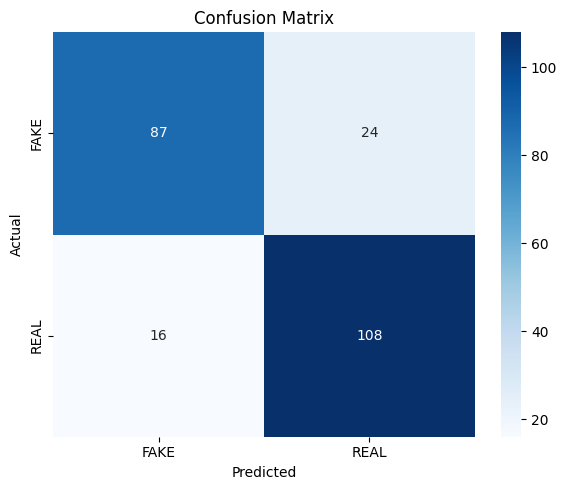

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
pred_probs = face_model.predict(X_test)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Get class names from the label encoder
class_names = label_encoder.classes_

# 🔍 Classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("📊 Classification Report:\n")
print(report)

# 🔲 Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
